In [1]:
import pandas as pd
from orion import Orion
from utils import plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

In [2]:
data = pd.read_csv('data/543341.csv', usecols=['Date', 'No. of Trades'], parse_dates=['Date'])
data.rename(columns={'No. of Trades': 'value', 'Date': 'timestamp'}, inplace=True)
data.sort_values(by='timestamp', inplace=True)
data.timestamp = (data.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
data.head()

,timestamp,value
244,1647302400,3
243,1648166400,1
242,1648425600,1
241,1648512000,2
240,1648598400,2


In [3]:
known_anomalies = pd.DataFrame({
    'start': [1648751400],
    'end': [1661970599]
})

In [4]:
known_anomalies

,start,end
0,1648751400,1661970599


## Arima

In [5]:
result = adfuller(data['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -3.721728
p-value: 0.003818
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573
Reject Ho - Time Series is Stationary


<AxesSubplot:>

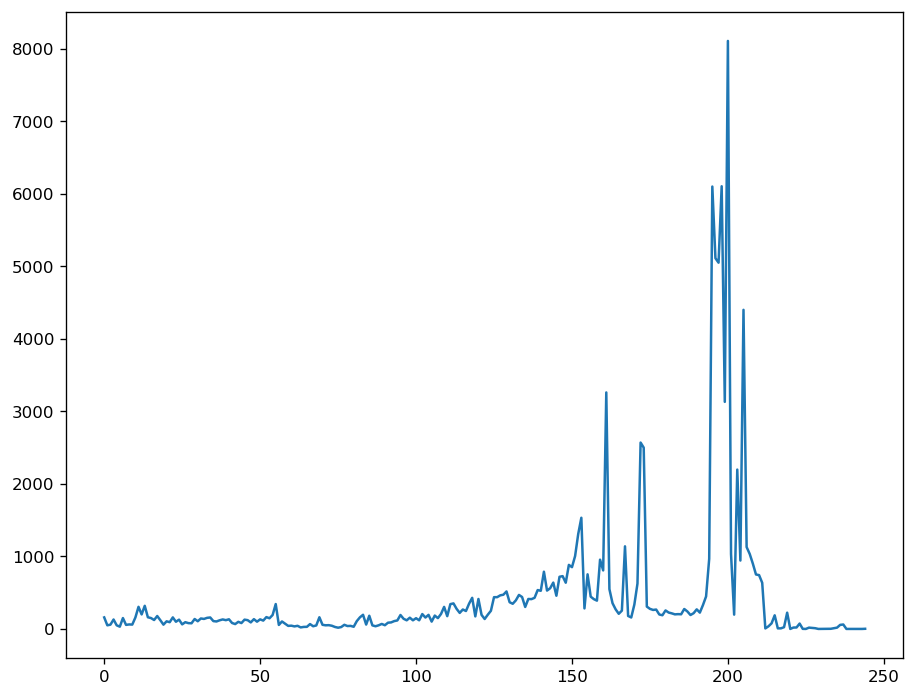

In [6]:
data['value'].plot()

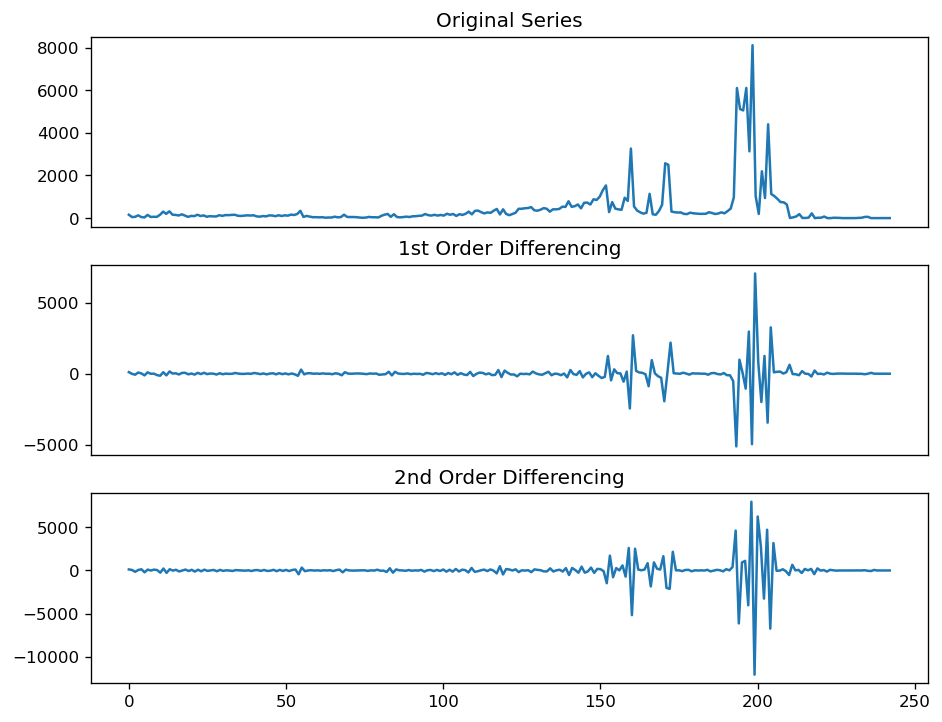

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data.value); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
ax2.plot(data.value.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
ax3.plot(data.value.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

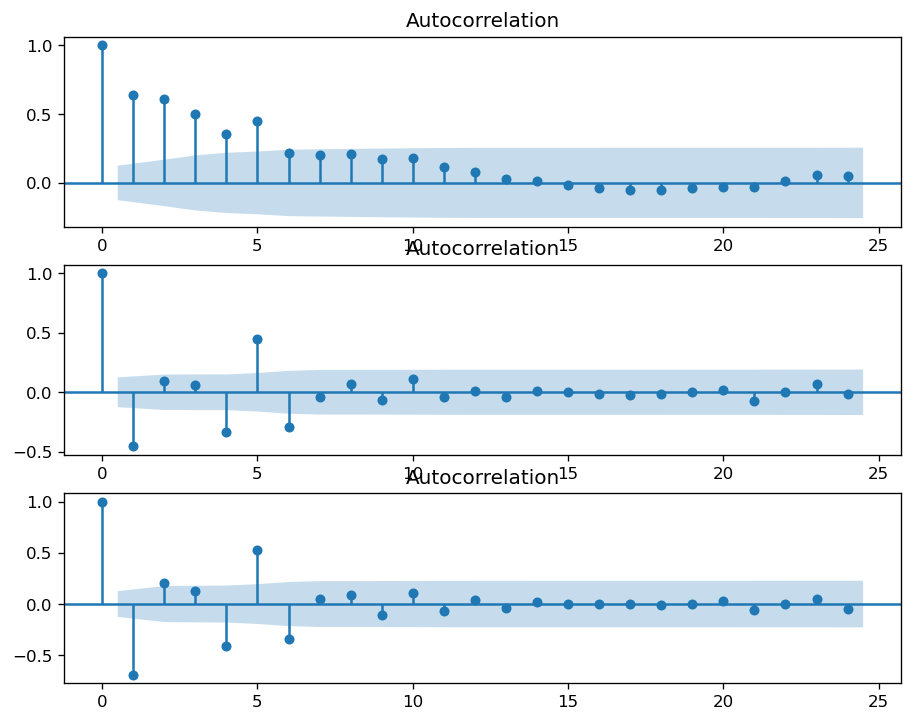

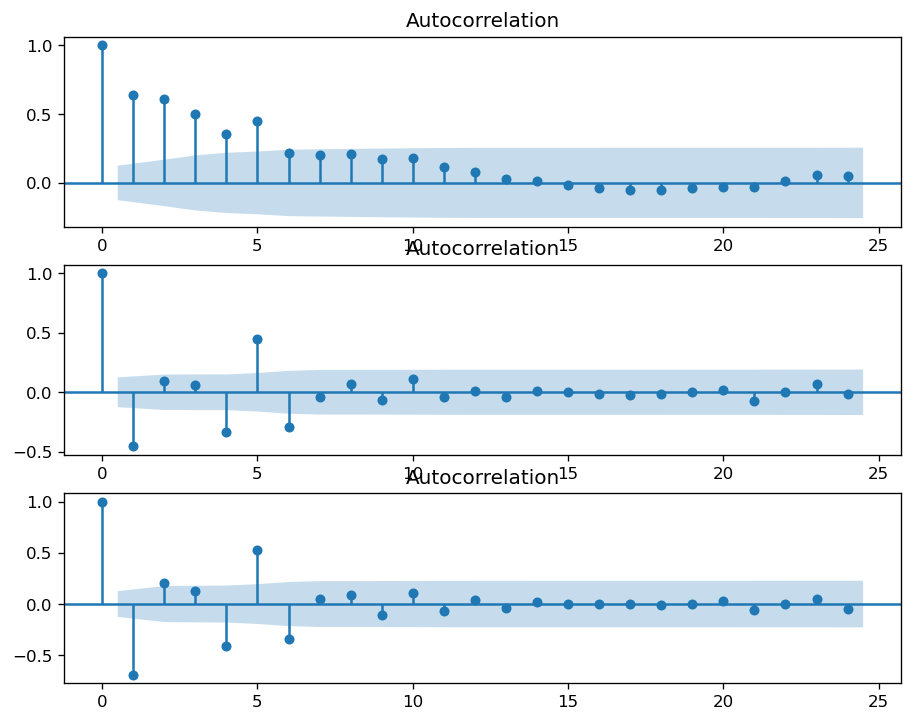

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data.value, ax=ax1)
plot_acf(data.value.diff().dropna(), ax=ax2)
plot_acf(data.value.diff().diff().dropna(), ax=ax3)

In [8]:
orion = Orion(
    'arima.json',
)

In [9]:
anomalies = orion.fit_detect(data)

/home/opc/.conda/envs/orion/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/opc/.conda/envs/orion/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to 

In [10]:
anomalies

,start,end,severity
0,1651320000,1654171200,2.077938


/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


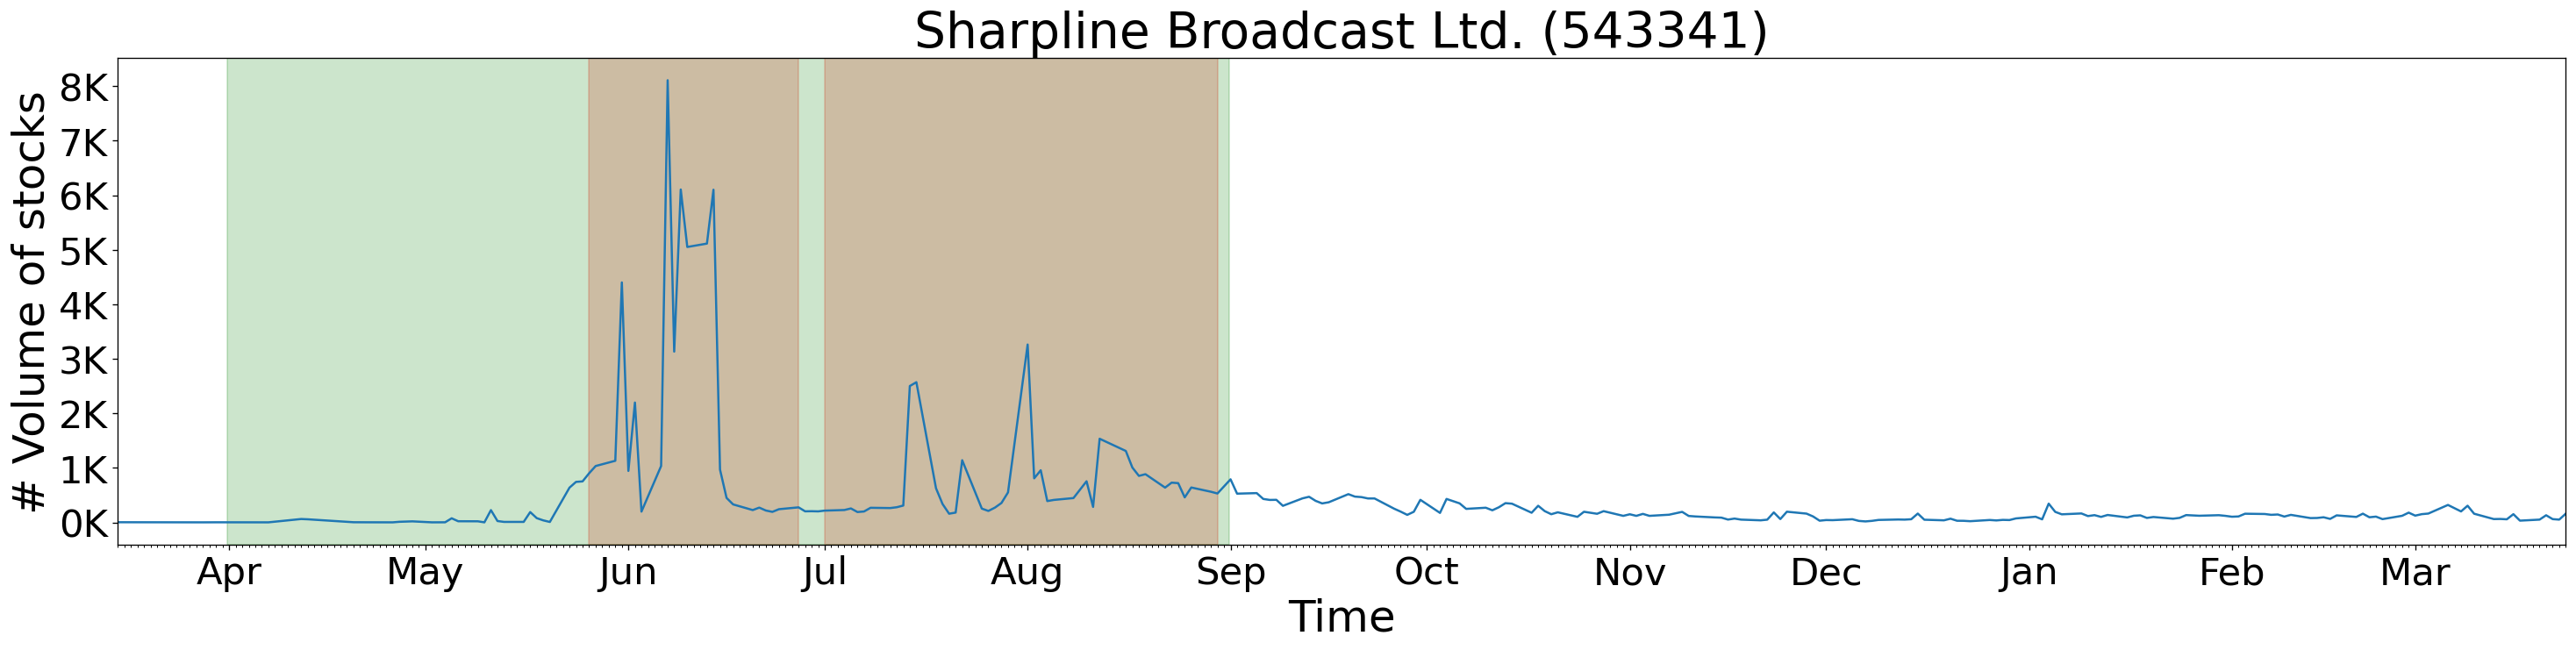

In [12]:
plot(data, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

## LSTM Autoencoder

In [13]:
hyperparameters = {
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0,
        'window_size': 100
    },
    'keras.Sequential.LSTMSeq2Seq#1': {
        'epochs': 15,
        'verbose': True,
        'window_size': 100,
        'input_shape': [100, 1],
        'target_shape': [100, 1]
    }
}

In [6]:
orion = Orion(
    pipeline='lstm_autoencoder',
    hyperparameters=hyperparameters
)

In [7]:
anomalies = orion.fit_detect(data)

2023-08-19 16:39:03.340384: W tensorflow/core/platform/profile_utils/cpu_utils.cc:108] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency
2023-08-19 16:39:03.340704: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xaaaadcf72200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-08-19 16:39:03.340727: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/15
18/18 [==============================] - 3s 143ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 2/15
18/18 [==============================] - 2s 112ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 3/15
18/18 [==============================] - 2s 112ms/step - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 4/15
18/18 [==============================] - 2s 111ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 5/15
18/18 [==============================] - 2s 111ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 6/15
18/18 [==============================] - 2s 112ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 7/15
18/18 [==============================] - 2s 113ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 8/15
18/18 [==============================] - 2s 114ms/step - loss: 0.

In [8]:
anomalies

,start,end,severity
0,1653523200,1656288000,1.403011
1,1656633600,1661817600,0.408251


In [9]:
orion.evaluate(data=data, ground_truth=known_anomalies)

22/22 [==============================] - 1s 36ms/step


accuracy     0.836898
f1           0.751021
recall       0.601307
precision    1.000000
dtype: float64

In [28]:
#Slice data after timestamp 1640975400
data_t = data[data.timestamp > 1640975400]
print(data_t.shape)

(296, 2)


/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


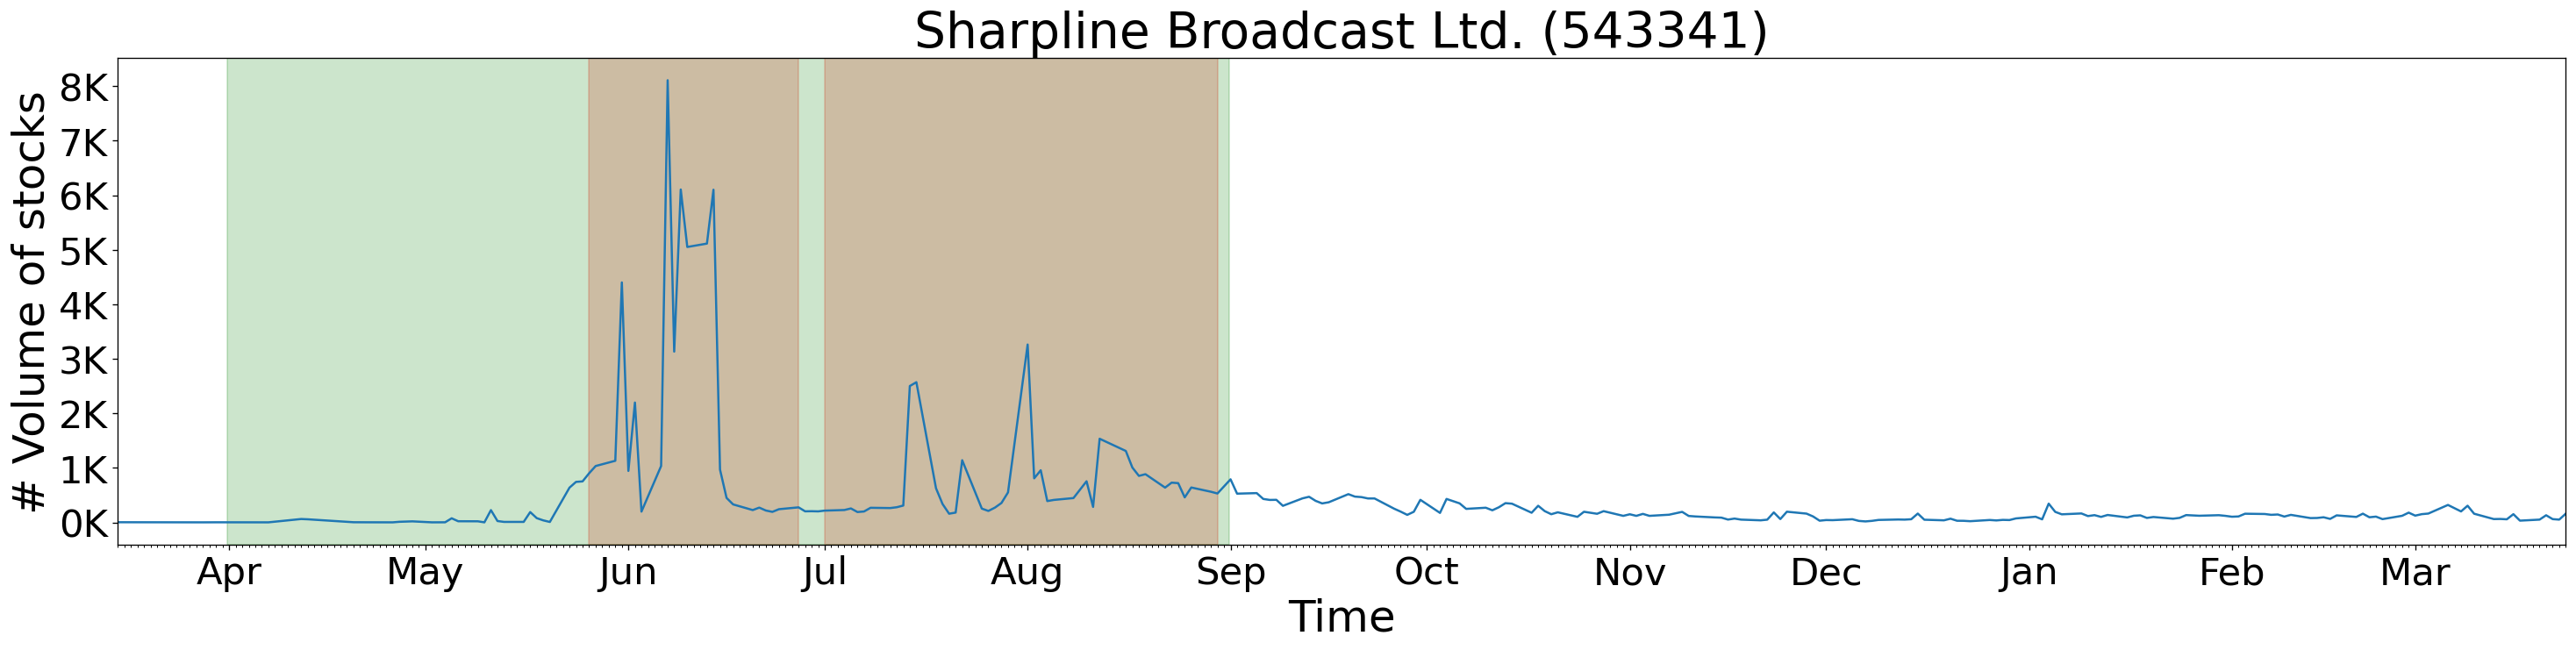

In [14]:
plot(data, 'Sharpline Broadcast Ltd. (543341)', anomalies=[anomalies, known_anomalies])

## LSTM with Dynamic Thresholding

In [15]:
hyperparameters = {
    "mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences#1": {
        'target_column': 0
    },
    'keras.Sequential.LSTMTimeSeriesRegressor#1': {
        'epochs': 5,
        'verbose': True
    }
}

In [16]:
orion = Orion(
    pipeline='lstm_dynamic_threshold',
    hyperparameters=hyperparameters
)

In [17]:
anomalies = orion.fit(data)

Epoch 1/5
16/16 [==============================] - 6s 391ms/step - loss: 0.1068 - mse: 0.1068 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 2/5
16/16 [==============================] - 6s 357ms/step - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/5
16/16 [==============================] - 6s 360ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/5
16/16 [==============================] - 6s 354ms/step - loss: 0.0220 - mse: 0.0220 - val_loss: 8.8118e-04 - val_mse: 8.8118e-04
Epoch 5/5
16/16 [==============================] - 6s 354ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 8.8475e-04 - val_mse: 8.8475e-04


In [19]:
anomalies

In [ ]:
plot(data, [anomalies, known_anomalies])

## TadGAN

In [32]:
parameters = {
  'mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1': {
    "interval": 3600
  },
}

In [33]:
orion = Orion(
    'tadgan.json',
    parameters
)

In [34]:
anomalies = orion.fit_detect(data)

{'shape': (100, 1), 'target_shape': (100, 1), 'input_dim': 1, 'output_dim': 1, 'generator_reshape_dim': 50, 'generator_reshape_shape': (50, 1), 'encoder_reshape_shape': (20, 1)}
Epoch: 1/5, Losses: {'cx_loss': -4.9785, 'cz_loss': -14.3072, 'eg_loss': 6.4761}
Epoch: 2/5, Losses: {'cx_loss': -0.7961, 'cz_loss': -5.8327, 'eg_loss': 14.9886}
Epoch: 3/5, Losses: {'cx_loss': 2.7051, 'cz_loss': -7.7265, 'eg_loss': -40.2207}
Epoch: 4/5, Losses: {'cx_loss': -0.9808, 'cz_loss': -1.5346, 'eg_loss': -11.4923}
Epoch: 5/5, Losses: {'cx_loss': -0.9905, 'cz_loss': 1.3977, 'eg_loss': -16.2469}


In [35]:
anomalies

,start,end,severity
0,1654412400,1655377200,1.578162
1,1657540800,1658095200,0.577260
2,1659020400,1659654000,0.611242
3,1660467600,1660960800,0.176893


In [36]:
data_t = data[data.timestamp > 1640975400]

/home/opc/src/orion/utils.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


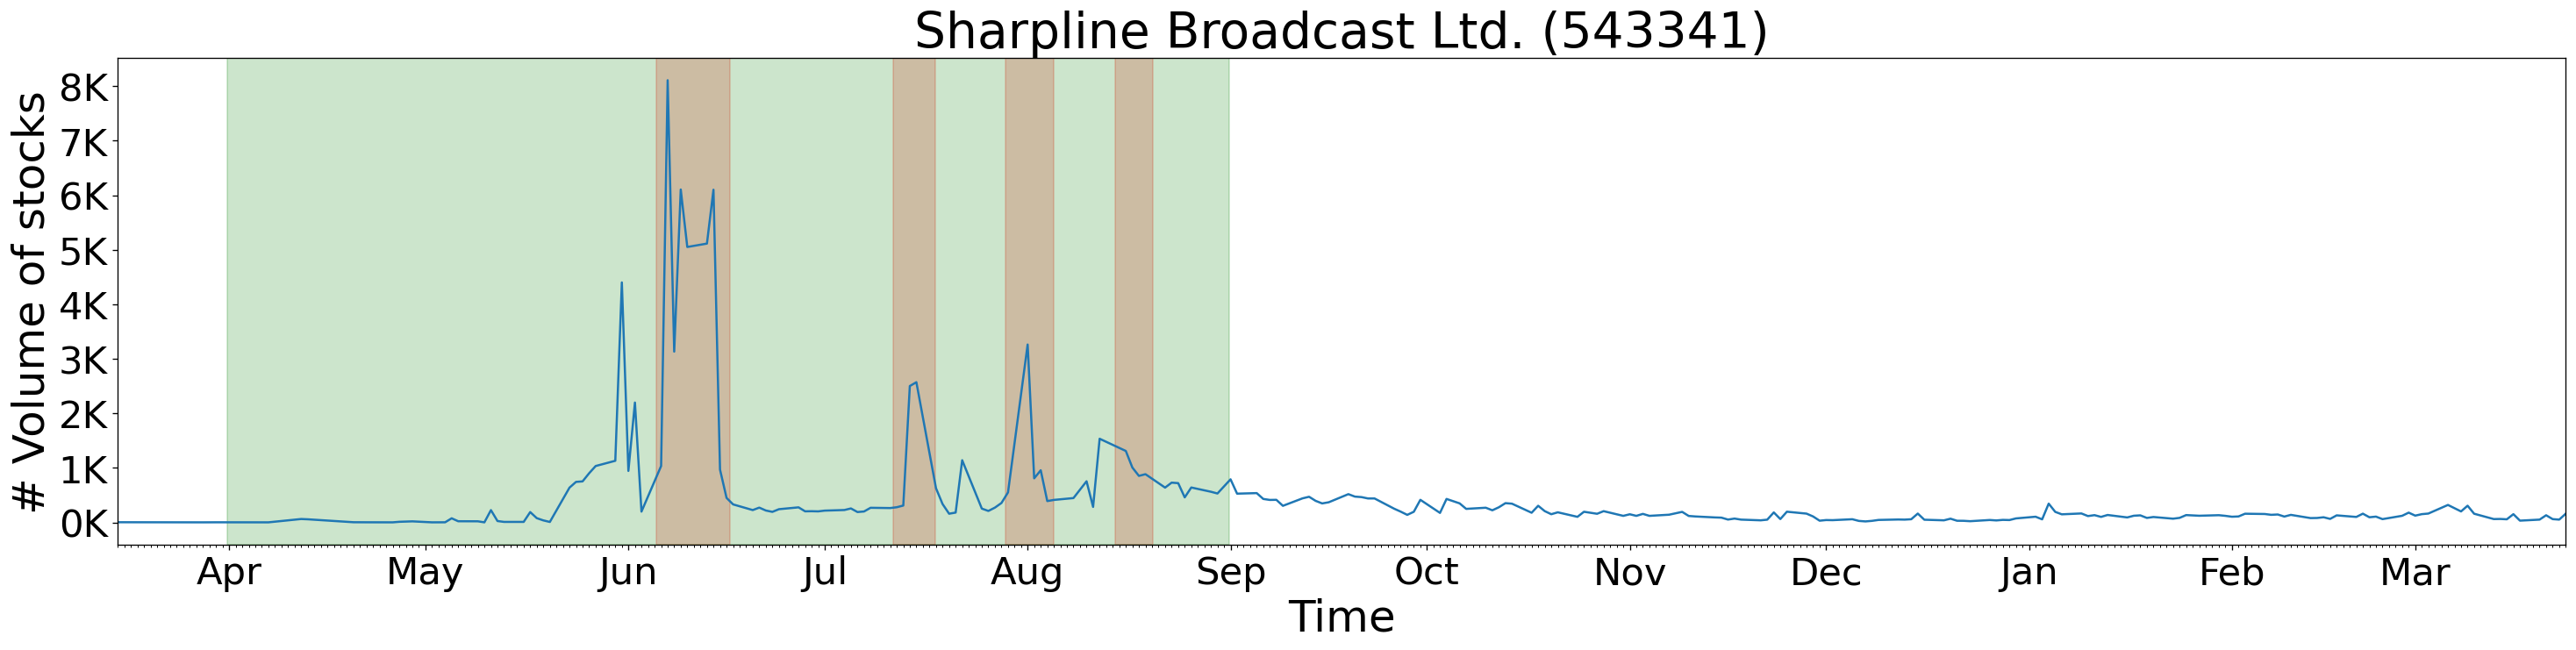

In [36]:
plot(data, 'Sharpline Broadcast Ltd. (543341)' ,[anomalies, known_anomalies])

In [37]:
orion.evaluate(data=data, ground_truth=known_anomalies)

accuracy     0.672794
f1           0.333561
recall       0.200164
precision    1.000000
dtype: float64

## AER

In [ ]:
orion = Orion(
    'aer.json',
    parameters
)

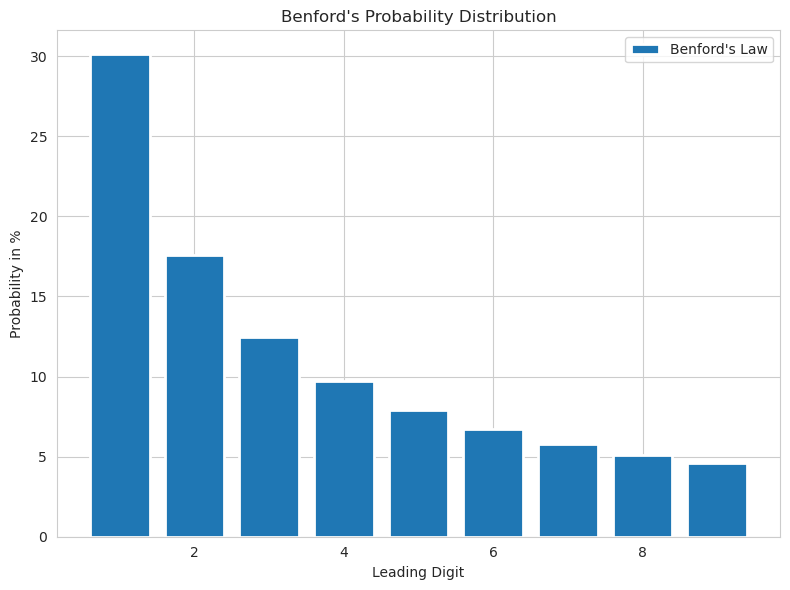

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def benfords_law():
    # Initialize a list to store the frequency of each digit (1-9)
    digit_frequencies = [0] * 9
    
    # Read the data from a file or generate your own data
    # For demonstration purposes, let's generate random numbers
    data = np.random.uniform(1, 1000, 1000)
    
    # Iterate through each data point
    for num in data:
        first_digit = int(str(num)[0])  # Get the first digit of the number
        
        # Increment the frequency of the corresponding digit
        digit_frequencies[first_digit - 1] += 1
        
    # Calculate the total count
    total_count = sum(digit_frequencies)
    
    # Calculate the expected Benford's Law frequencies
    benfords_frequencies = [np.log10(1 + (1 / digit)) * total_count for digit in range(1, 10)]
    log_frequencies = [np.log(digit_frequency) for digit_frequency in digit_frequencies]
    benfords_frequencies = [frequency/10 for frequency in benfords_frequencies]
    
    # Plot the results using seaborn
    digits = range(1, 10)
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 6))
    plt.bar(digits, benfords_frequencies, label="Benford's Law", linewidth=2)
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability in %')
    plt.title("Benford's Probability Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to generate the graph
benfords_law()


/tmp/ipykernel_896748/853952884.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(digits, benfords_frequencies, 'r-', label="Benford's Law", linewidth=2, marker='o', markersize=6, color='salmon')
/tmp/ipykernel_896748/853952884.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


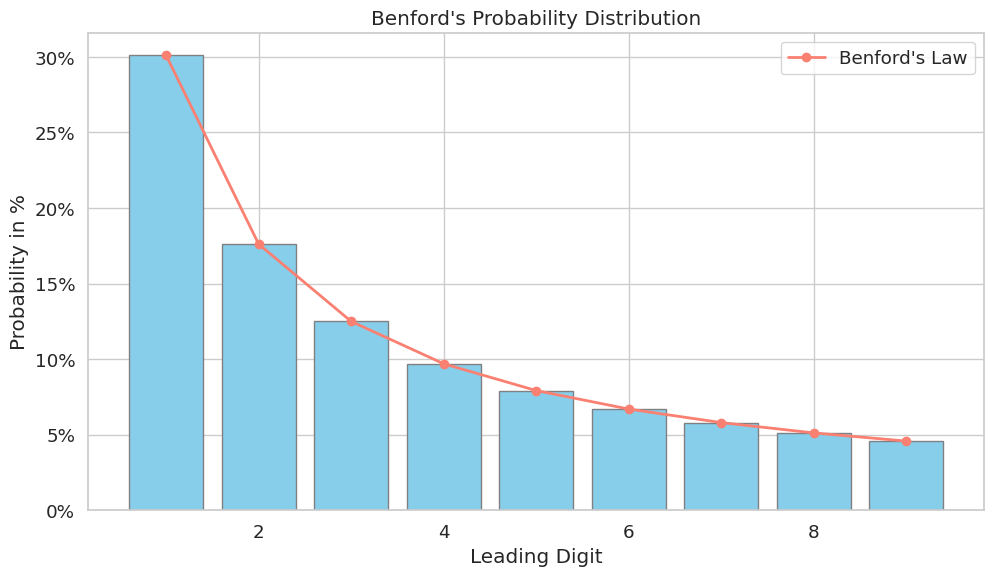

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def benfords_law():
    # Initialize a list to store the frequency of each digit (1-9)
    digit_frequencies = [0] * 9
    
    # Read the data from a file or generate your own data
    # For demonstration purposes, let's generate random numbers
    data = np.random.uniform(1, 1000, 1000)
    
    # Iterate through each data point
    for num in data:
        first_digit = int(str(num)[0])  # Get the first digit of the number
        
        # Increment the frequency of the corresponding digit
        digit_frequencies[first_digit - 1] += 1
        
    # Calculate the total count
    total_count = sum(digit_frequencies)
    
    # Calculate the expected Benford's Law frequencies
    benfords_frequencies = [np.log10(1 + (1 / digit)) * total_count for digit in range(1, 10)]
    benfords_frequencies = [frequency/10 for frequency in benfords_frequencies]
    
    # Plot the results using seaborn
    digits = range(1, 10)
    sns.set(style='whitegrid', font_scale=1.2)
    plt.figure(figsize=(10, 6))
    plt.bar(digits, benfords_frequencies, alpha=1, color='skyblue', edgecolor='gray')
    plt.plot(digits, benfords_frequencies, 'r-', label="Benford's Law", linewidth=2, marker='o', markersize=6, color='salmon')
    plt.xlabel('Leading Digit')
    plt.ylabel('Probability in %')
    plt.title("Benford's Probability Distribution")
    plt.legend()
    plt.tight_layout()
    # Show plt ticks in format {num}%
    plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
    plt.show()


# Call the function to generate the graph
benfords_law()
